In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [6]:
expSum = data.n_clicks[data.slot == 'exp'].sum()
controlSum = data.n_clicks[data.slot == 'control'].sum()

In [8]:
(expSum/controlSum - 1)*100

1.6135689824415822

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


In [13]:
exps = data.n_clicks[data.slot == 'exp'].values
controls = data.n_clicks[data.slot == 'control'].values

In [16]:
np.random.seed(0)
num_of_samples = 500
exps_bs = get_bootstrap_samples(exps, num_of_samples)
control_bs = get_bootstrap_samples(controls, num_of_samples)

In [17]:
exp_cl_mean, ctrl_cl_mean = np.empty(num_of_samples), np.empty(num_of_samples)
exp_cl_median, ctrl_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)

ctrl_cl_var = np.empty(num_of_samples)

for i in range(num_of_samples):
    exp_cl_mean[i], ctrl_cl_mean[i] = exps_bs[i].mean(), control_bs[i].mean() 
    exp_cl_median[i], ctrl_cl_median[i] = np.median(exps_bs[i]), np.median(control_bs[i])
    
    ctrl_cl_var[i] = control_bs[i].var()

In [19]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_cl_mean, ctrl_cl_mean)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_cl_median, ctrl_cl_median)))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

Conf. int. delta mean: [0.1996, 0.4050]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


Text(0.5, 1.0, 'Probability plot for means')

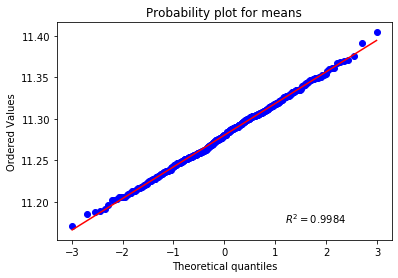

In [20]:
stats.probplot(ctrl_cl_mean, plot=plt, rvalue=True)
plt.title('Probability plot for means')

Text(0.5, 1.0, 'Probability plot for variances')

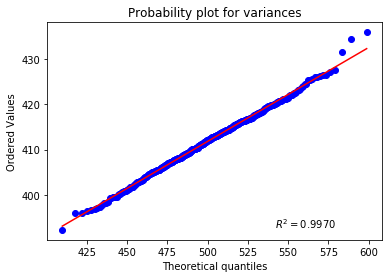

In [21]:
stats.probplot(ctrl_cl_var, plot=plt, dist='chi2', sparams=(ctrl_cl_mean.shape[0]-1), rvalue=True)
plt.title('Probability plot for variances')

In [34]:
data.browser = [int(data.browser[i][9:]) for i in range(data.shape[0])]

In [35]:
expClick = data[data.slot == 'exp'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
ctrlClick = data[data.slot == 'control'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

In [36]:
stats.mannwhitneyu(expClick, ctrlClick, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

In [38]:
browsers_nclicks_exp = data[data.slot == 'exp'].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = data[data.slot == 'exp'].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']


In [39]:
browsers = np.unique(data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: [ 2  4 14 17 20 22]

Mann-Whitney rank test without multipletest
Browser #2: 
p-value = 1.0000
Browser #4: 
p-value = 1.0000
Browser #14: 
p-value = 1.0000
Browser #17: 
p-value = 1.0000
Browser #20: 
p-value = 1.0000
Browser #22: 
p-value = 1.0000

Mann-Whitney rank test with multipletest
Browser #2: 
p-value = 1.0000
Browser #4: 
p-value = 1.0000
Browser #14: 
p-value = 1.0000
Browser #17: 
p-value = 1.0000
Browser #20: 
p-value = 1.0000
Browser #22: 
p-value = 1.0000


In [41]:
browsers_nonclk_q_exp = data.loc[exp].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = data.loc[exp].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = data.loc[ctrl].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = data.loc[ctrl].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser #%d' % br),
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print('/'),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)

NameError: name 'exp' is not defined